# 毕业论文`GRAD`
## `MEIC`排放量变化分析

---
*@author: Evan*\
*@date: 2023-11-22*

In [108]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from cnmaps import get_adm_maps, clip_quiver_by_map, clip_contours_by_map, clip_pcolormesh_by_map,draw_map
import geopandas as gpd
from shapely.ops import unary_union

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../src/')
from namelist import *
from mask import polygon_to_mask, average_data

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [55]:
year = 2014
month = 9

var = 'NOx'

In [99]:
def read_asc_file(file_path, coordinate = False):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # 获取栅格尺寸
    ncols = int(lines[0].split()[1])
    nrows = int(lines[1].split()[1])
    xllcorner = float(lines[2].split()[1])
    yllcorner = float(lines[3].split()[1])
    cellsize = float(lines[4].split()[1])
    nodata_value = float(lines[5].split()[1])

    # 读取二维数据
    data = np.zeros((nrows, ncols))
    for i in range(nrows):
        row_data = lines[i + 6].split()
        for j in range(ncols):
            if row_data[j] == str(nodata_value):
                data[i, j] = np.nan
            else:
                data[i, j] = float(row_data[j])

    print(f'数据维度为: (y, x) = ({nrows}, {ncols})')
    print(f'数据左下角的经纬度为: ({yllcorner}N, {xllcorner}E)')
    print(f'数据分辨率为: {cellsize}')
    
    # 直接读取的数据是上下颠倒的，因此需要上下翻转
    data = np.flipud(data)
    
    if coordinate is True:
        return data, ncols, nrows, xllcorner, yllcorner, cellsize
    elif coordinate is False:
        return data


In [100]:
data, ncols, nrows, xllcorner, yllcorner, cellsize = read_asc_file(
    meicdata + f'{year}/{year}_{month:02d}_total_{var}.asc',
    coordinate=True)

lons = np.arange(xllcorner, xllcorner + ncols * cellsize, cellsize)
lats = np.arange(yllcorner, yllcorner + nrows * cellsize, cellsize)

lon,lat = np.meshgrid(lons,lats)

数据维度为: (y, x) = (200, 320)
数据左下角的经纬度为: (10.0N, 70.0E)
数据分辨率为: 0.25


In [117]:
cmax = 800
cmstep = 4
cbstep = 200

colormap = 'Spectral_r'
contourf_ticks = np.arange(0,cmax+0.001,cmstep)

colorbar_ticks = np.arange(0,cmax+0.001,cbstep)
colorbar_label = 'NO$_x$'

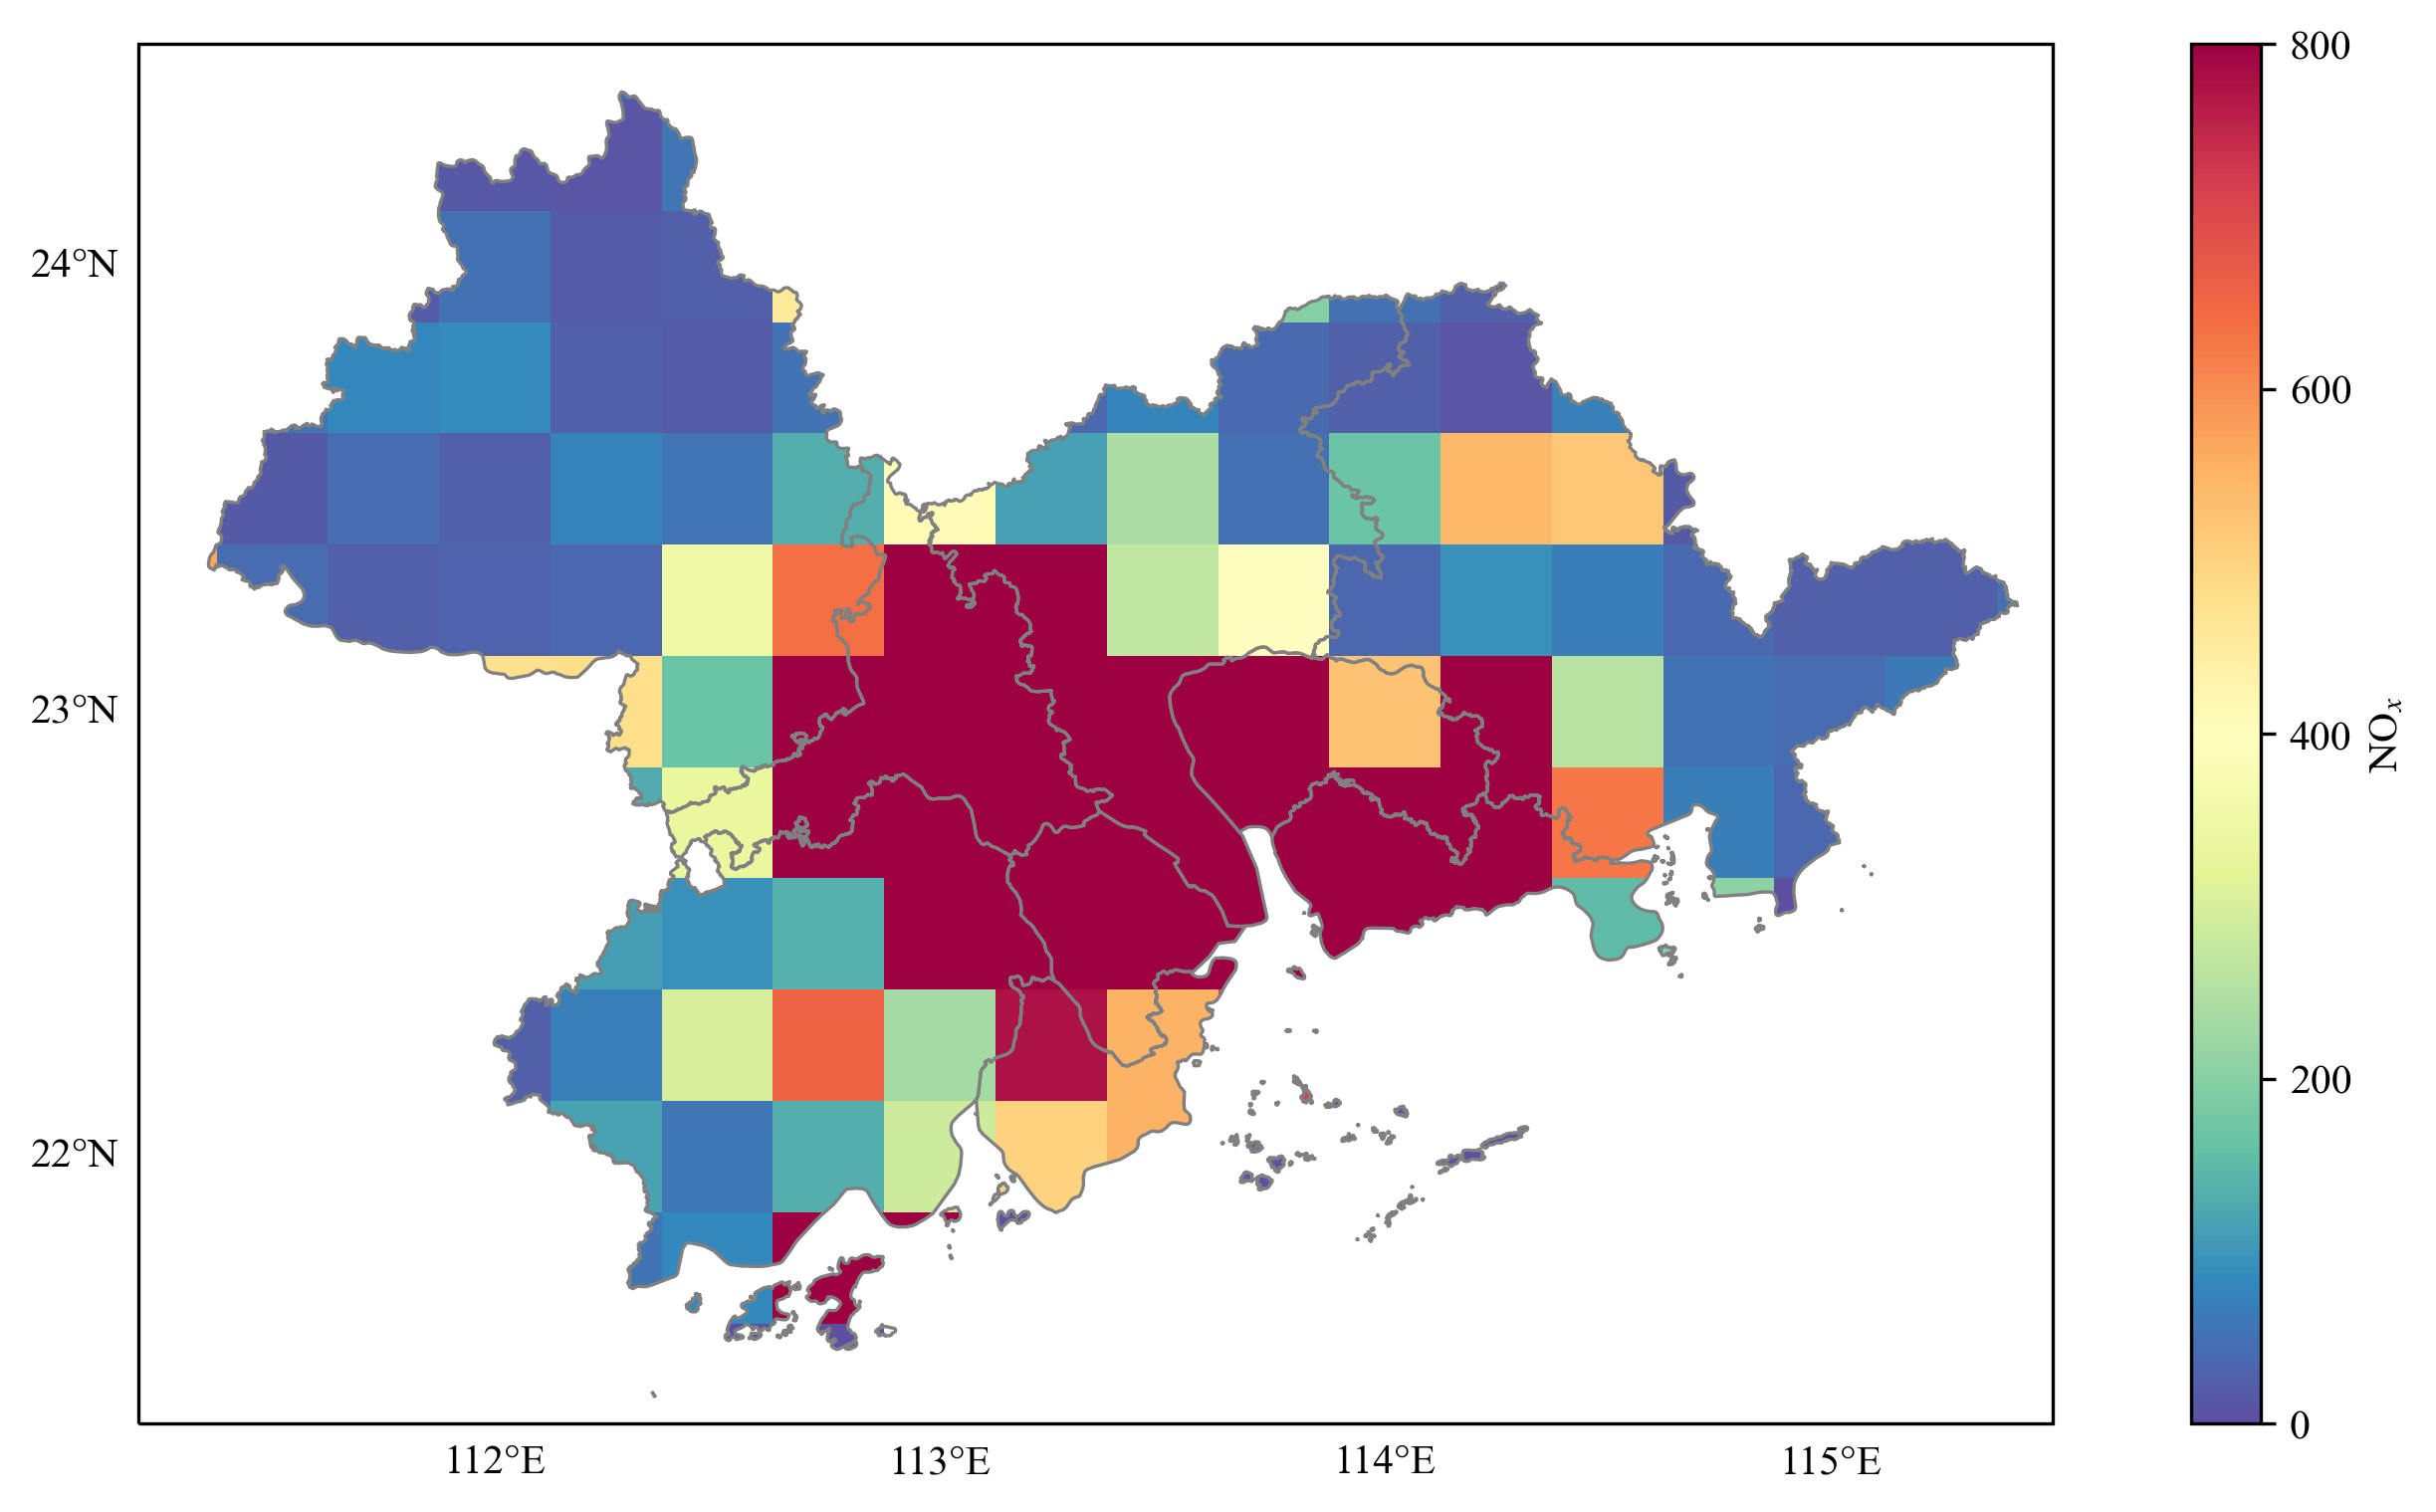

In [118]:
fig = plt.figure(figsize=(12, 6), dpi=300)
ax = fig.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

cities = ['广州市', '佛山市', '深圳市', '东莞市', '珠海市', '中山市', '惠州市', '江门市', '肇庆市']
multi_polygons = []

for city in cities:
    polygon = get_adm_maps(city=city, record='first', only_polygon=True)
    multi_polygons.append(polygon)
    draw_map(polygon, color='gray', linewidth=0.8)

map_polygon = unary_union(multi_polygons)

gl = ax.gridlines(
    xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
    draw_labels=True, x_inline=False, y_inline=False,
    linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False
gl.rotate_labels = False

ax.set_extent([111.2, 115.5, 21.4, 24.5], ccrs.PlateCarree())

cp = ax.pcolormesh(lon, lat, data,
                cmap=colormap,vmin=0,vmax=cmax,
                transform=ccrs.PlateCarree())

clip_pcolormesh_by_map(cp, map_polygon)

cbar = plt.colorbar(cp)
cbar.set_ticks(colorbar_ticks)
cbar.set_label(colorbar_label)

plt.show()